In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as rqs
from bs4 import BeautifulSoup
from IPython.display import clear_output
from time import sleep
from datetime import datetime

def single_team(df) :
    if len(df) == 1: # If player played for a single team, do nothing
        return df
    else: # If player has moved, return total stats with last team
        row = df[df['Tm'] == 'TOT'].copy()
        row['Tm'] = [str(df['Tm'].iloc[-1])]
        return row

def SoRareScore(df):

    df = df.apply(pd.to_numeric, errors = 'ignore')
    scores = []
    for pts, reb, ast, blk, stl, tov, fg_3 in zip(df['PTS'], df['TRB'], df['AST'], df['BLK'], df['STL'], df['TOV'], df['3P']) :
        
        score = 0
        if pts not in ['Inactive', 'Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended']:
            
            pts, reb, ast, blk, stl, tov, fg_3 = int(pts), int(reb), int(ast), int(blk), int(stl), int(tov), int(fg_3)

            score = 1 * pts + 1.2 * reb + 1.5 * ast + 3 * blk + 3 * stl + 1 * fg_3 - 2 * tov

            doubles = 0 # Count double-digits stats
            if pts >= 10 :
                doubles += 1
            if reb >= 10 :
                doubles += 1
            if ast >= 10 :
                doubles += 1
            if blk >= 10 :
                doubles += 1
            if stl >= 10 :
                doubles += 1

            if doubles == 2 : # Double-double
                score += 1

            if doubles >= 3 : # Tripe-double
                score += 2
        
        else :
            score = 'dnp'

        scores.append(score)
    return scores

def mins_played(str) :
    min, sec = str.split(':')
    return float(min) + float(sec) / 60

In [2]:
# Get list of player hrefs
url = f'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'
page = rqs.get(url)
soup = BeautifulSoup(page.content, 'html')
while soup.find('tr', class_ = 'thead') is not None :
    soup.find('tr', class_ = 'thead').decompose()

table = soup.find('table')
data_live = pd.read_html(str(table))[0]
del data_live['Rk']
hrefs = []
for x in table.find_all('a', href = True):
    if x['href'].split('/')[1] == 'players' :
        hrefs.append(x['href'][:-5])
data_live['href'] = hrefs
data_live = data_live.groupby('Player').apply(single_team)
data_live = data_live.sort_values('PTS', ascending = False).reset_index(drop = True)

data_live.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,href
0,Joel Embiid,C,28,PHI,25,25,35.8,11.2,21.2,0.529,...,1.8,7.9,9.7,4.3,1.2,1.6,3.8,3.3,33.7,/players/e/embiijo01
1,Luka Dončić,PG,23,DAL,32,32,37.0,11.4,22.5,0.506,...,1.0,7.7,8.7,8.8,1.7,0.6,3.8,2.9,33.6,/players/d/doncilu01
2,Shai Gilgeous-Alexander,SG,24,OKC,31,31,35.8,10.5,20.7,0.505,...,0.8,4.1,4.9,5.8,1.7,1.1,3.4,2.6,31.5,/players/g/gilgesh01
3,Giannis Antetokounmpo,PF,28,MIL,28,28,33.3,11.2,20.9,0.536,...,2.1,9.1,11.2,5.1,0.9,0.9,3.8,3.6,31.2,/players/a/antetgi01
4,Jayson Tatum,PF,24,BOS,33,33,37.0,10.2,21.4,0.477,...,1.1,6.9,8.1,4.1,1.2,0.9,2.7,2.2,31.1,/players/t/tatumja01
5,Stephen Curry,PG,34,GSW,26,26,34.4,10.1,20.2,0.500,...,0.6,6.0,6.6,6.8,1.0,0.3,3.1,2.1,30.0,/players/c/curryst01
6,Kevin Durant,PF,34,BRK,33,33,36.4,10.7,19.1,0.563,...,0.3,6.3,6.6,5.3,0.8,1.5,3.5,2.5,30.0,/players/d/duranke01
7,Donovan Mitchell,SG,26,CLE,31,31,36.3,9.9,20.1,0.492,...,0.9,2.9,3.8,4.5,1.4,0.4,2.9,2.6,28.5,/players/m/mitchdo01
8,LeBron James,PF,38,LAL,26,26,35.8,11.0,22.1,0.497,...,1.3,6.8,8.0,6.6,1.1,0.6,3.0,1.8,27.8,/players/j/jamesle01
9,Damian Lillard,PG,32,POR,22,22,35.1,8.3,18.8,0.441,...,0.6,3.2,3.8,7.2,0.8,0.3,3.5,1.9,27.5,/players/l/lillada01


In [3]:
data_live['SORARE'] = SoRareScore(data_live)

In [5]:
data = data_live[(data_live['SORARE'] >= 20) & (data_live['SORARE'] < 25) & (data_live['G'] >= 10)]
data['S_mp'] = data['SORARE'] / data['MP']
data.sort_values('G', ascending=False).head(25)

/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_82682/839094283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['S_mp'] = data['SORARE'] / data['MP']


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,href,SORARE,S_mp
102,Malik Beasley,SG,26,UTA,34,5,27.3,5.1,12.3,0.416,...,3.7,1.5,0.9,0.1,1.0,1.3,14.1,/players/b/beaslma01,20.1,0.736264
55,Jordan Poole,SG,23,GSW,32,13,28.8,6.6,15.0,0.437,...,2.2,4.5,0.8,0.3,3.2,2.3,19.3,/players/p/poolejo01,23.4,0.812500
197,Jarred Vanderbilt,PF,23,UTA,32,30,24.8,3.5,6.2,0.571,...,8.2,2.8,1.2,0.3,1.5,2.8,8.6,/players/v/vandeja01,21.6,0.870968
116,Kelly Olynyk,PF,31,UTA,32,32,28.6,4.3,8.3,0.527,...,5.0,3.2,1.2,0.6,2.3,4.0,12.9,/players/o/olynyke01,22.5,0.786713
125,Bol Bol,PF,23,ORL,32,27,26.3,5.0,8.4,0.593,...,7.3,1.1,0.5,1.7,2.0,1.3,12.2,/players/b/bolbo01,20.9,0.794677
66,Bennedict Mathurin,SG,20,IND,31,1,29.0,5.6,13.6,0.415,...,4.1,1.5,0.6,0.1,1.8,1.9,17.9,/players/m/mathube01,22.3,0.768966
170,Mason Plumlee,C,32,CHO,31,31,27.5,3.7,6.2,0.604,...,9.3,4.0,0.6,0.6,1.8,3.4,9.8,/players/p/plumlma01,23.8,0.865455
163,Ivica Zubac,C,25,LAC,30,30,29.5,4.0,6.4,0.617,...,10.8,1.1,0.4,1.6,2.1,3.1,10.1,/players/z/zubaciv01,23.5,0.796610
97,P.J. Washington,PF,24,CHO,30,30,31.8,5.4,13.4,0.405,...,4.9,2.3,0.8,1.0,1.6,2.6,14.4,/players/w/washipj01,23.8,0.748428
105,Luguentz Dort,SG,23,OKC,30,30,30.3,4.8,11.9,0.402,...,4.4,2.4,1.0,0.3,1.5,3.3,13.9,/players/d/dortlu01,22.8,0.752475


In [30]:
data = data_live[(data_live['PTS'] >= 7) & (data_live['PTS'] <= 12)]
features = ['form_1', 'form_2', 'form_5', 'form_10', 'mean_score']
players_info = []
for player, href in zip(data['Player'], data['href']) :
    clear_output(wait = True)
    print(f'Fetching {player} games ...')
    url = f'https://www.basketball-reference.com{href}/gamelog/2023'

    page = rqs.get(url)
    soup = BeautifulSoup(page.content, 'html')
    while soup.find('tr', class_ = 'thead') is not None :
        soup.find('tr', class_ = 'thead').decompose()

    table = soup.find('table', id = 'pgl_basic')
    df = pd.read_html(str(table))[0][['Date', 'Tm', 'G', 'MP', 'PTS', 'TRB', 'AST', 'BLK', 'STL', 'TOV', '3P']]
    df.insert(0, 'Player', len(df) * [player])
    df = df.apply(pd.to_numeric, errors = 'ignore')
    df['SORARE'] = SoRareScore(df)
    df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    df = df.sort_values('Date')
    df['SORARE'] = df['SORARE'].replace('dnp', np.nan)

    df_past = df[df['Player'].notna()]
    df_pred = df[df['Player'].isna()]

    form_1 = df_past['SORARE'].tail(1).mean()
    form_2 = df_past['SORARE'].tail(2).mean()
    form_5 = df_past['SORARE'].tail(5).mean()
    form_10 = df_past['SORARE'].tail(10).mean()
    if (df_past['SORARE'].tail(10).isna()).sum() == 10:
        cost = np.nan
    else:
        df_cost = df_past[df_past['SORARE'].notna()]
        cost = round(df_cost['SORARE'].tail(10).mean())
    form_25 = df_past['SORARE'].tail(25).mean()
    stdev = df_past['SORARE'].std()
    
    player_form = pd.DataFrame([[player, cost, stdev,  form_1, form_2, form_5, form_10, form_25]],
                                            columns = ['Player', 'Cost', 'Std.'] + features)

    players_info.append(player_form)
    sleep(2)
    
my_data = pd.concat(players_info).reset_index(drop = True)

Fetching Josh Green games ...


In [36]:
test = pd.concat(players_info).reset_index(drop = True).sort_values('Std.', ascending = False)

Ivica Zubac
Kevin Love
Cam Reddish
Jevon Carter
Jaden McDaniels
Bruce Brown
Steven Adams
Derrick White
Marvin Bagley III
Tre Mann
Isaiah Jackson
Nick Richards
Draymond Green
Herbert Jones
Royce O'Neale
Mike Conley
Jeremy Sochan
Gabe Vincent
Obi Toppin
Isaiah Stewart


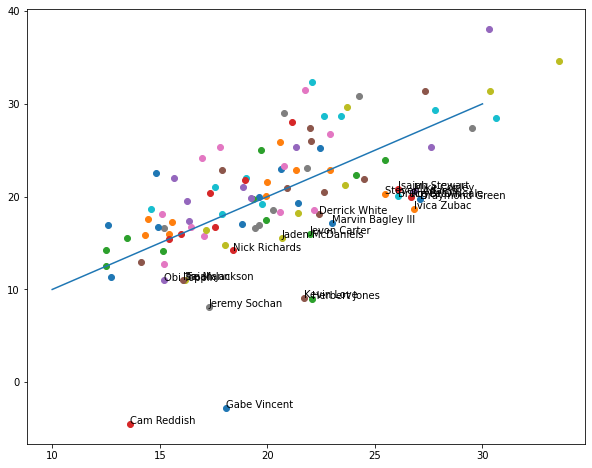

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 8))
for x, y, player in zip(test.mean_score, test.form_5, test.Player):
    plt.scatter(x, y)
    if x - y > 4:
        plt.annotate(player, xy = (x, y))
        print(player)

plt.plot([10, 30], [10, 30])

In [31]:
page = rqs.get(url)
table = page.text.split(f'<div class="table_container current" id="div_per_poss">')[1].split('</table>')[0] + '</table>'
soup = BeautifulSoup(table, 'html')
soup

IndexError: list index out of range

In [18]:
data_live[(data_live['SORARE'] > 16) & (data_live['SORARE'] < 22)].sort_values('SORARE').head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,href,SORARE
170,Derrick White,SG,28,BOS,35,28,26.1,3.3,7.5,0.439,...,2.5,3.1,3.1,0.8,0.8,1.0,2.3,9.8,/players/w/whitede01,16.1
148,Shake Milton,SG,26,PHI,29,8,24.4,4.2,8.2,0.506,...,2.6,3.2,3.2,0.4,0.2,1.6,1.8,10.8,/players/m/miltosh01,16.1
189,Nick Richards,C,25,CHO,33,0,18.8,3.4,5.5,0.615,...,3.5,6.4,0.6,0.2,0.8,0.8,2.3,9.0,/players/r/richani01,16.2
250,Walker Kessler,C,21,UTA,33,6,18.3,2.9,3.9,0.744,...,3.9,6.3,0.6,0.2,1.8,0.7,2.3,6.8,/players/k/kesslwa01,16.2
185,Grant Williams,PF,24,BOS,34,14,27.9,3.2,6.2,0.514,...,3.5,4.6,1.6,0.8,0.3,0.9,2.6,9.2,/players/w/willigr01,16.3
149,Kemba Walker,PG,32,DAL,6,1,20.7,3.5,8.5,0.412,...,2.2,2.7,2.8,0.0,0.3,0.7,1.7,10.8,/players/w/walkeke02,16.4
209,Torrey Craig,SF,32,PHO,32,24,24.7,3.2,6.7,0.479,...,3.3,5.3,1.6,0.8,0.7,0.7,2.4,8.4,/players/c/craigto01,16.5
202,Jeremiah Robinson-Earl,PF,22,OKC,26,18,21.1,3.3,6.7,0.489,...,3.0,5.0,1.0,0.7,0.4,0.6,1.9,8.5,/players/r/robinje02,16.5
142,Austin Reaves,SG,24,LAL,32,10,29.3,3.6,6.8,0.528,...,2.3,3.0,2.1,0.6,0.4,1.3,1.6,11.2,/players/r/reaveau01,16.6
292,Delon Wright,PG,30,WAS,6,0,20.5,2.0,5.0,0.400,...,1.2,1.8,3.7,2.5,0.7,0.7,1.3,5.8,/players/w/wrighde01,16.7
